In [1]:
import wandb

wandb.login()

wandb: Currently logged in as: kazadaevms. Use `wandb login --relogin` to force relogin


True

In [2]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path

f = np.load(str(Path('../data/features_(n_iterations, n_wells, n_dates, n_features).npy')))
t = np.load(str(Path('../data/targets_(n_iterations, n_wells, n_dates).npy')))

N_ITERATIONS, N_WELLS, N_DATES, N_FEATURES = f.shape
assert t.shape == (N_ITERATIONS, N_WELLS, N_DATES)

print(f.shape)
print(t.shape)

assert np.isnan(t).sum() == 0
print(np.isnan(f).sum() / np.prod(f.shape) * 100, '% NaNs')

for iteration in range(N_ITERATIONS):
    for well in range(N_WELLS):
        df = pd.DataFrame(f[iteration, well])
        f[iteration, well] = df.bfill().ffill().values
assert np.isnan(f).sum() == 0

f = torch.from_numpy(f).to(torch.float32)
t = torch.from_numpy(t).to(torch.float32)
t = t - t.mean(axis=0)

(884, 10, 114, 3)
(884, 10, 114)
15.263157894736842 % NaNs


In [12]:
import torch
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from IPython.display import clear_output


def train_loop(model, optimizer, criterion, train_loader) -> float:
    """
    Return RMSE
    """
    train_loss = 0.0
    model.train()
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(features).squeeze()
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.shape[0]
    train_loss /= len(train_loader.dataset)
    return np.sqrt(train_loss)


@torch.no_grad()
def val_loop(model, criterion, val_loader) -> float:
    """
    Return RMSE
    """
    val_loss = 0.0
    model.eval()
    for features, labels in val_loader:
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features).squeeze()
        loss = criterion(predictions, labels)
        val_loss += loss.item() * features.shape[0]
    val_loss /= len(val_loader.dataset)
    return np.sqrt(val_loss)


def plot(epochs: list[int], train_losses: list[float], val_losses: list[float], baseline_rmse: float, plot_baseline: bool):
    if plot_baseline:
        plt.axhline(baseline_rmse, linestyle='dashed', label='baseline')
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, val_losses, label='test')
    plt.title('RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


def train_nn(model, optimizer, criterion, scheduler, train_loader, val_loader, n_epochs: int, baseline_rmse: float, plot_baseline: bool):
    train_losses, val_losses = [], []
    lrs = []

    for epoch in range(1, n_epochs + 1):
        # Train
        start_time = timer()
        train_loss = train_loop(model, optimizer, criterion, train_loader)
        train_losses.append(train_loss)
        train_time = timer() - start_time

        # Validation
        start_time = timer()
        val_loss = val_loop(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_time = timer() - start_time

        # Log lr
        lr = next(iter(optimizer.param_groups))['lr']
        lrs.append(lr)

        # Scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Log record
        record = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'lr': lr,
            'train_time': train_time,
            'val_time': val_time,
        }
        wandb.log(record)

        # Plot
        if epoch % 50 == 0:
            clear_output()
            print(f'Epoch={epoch}')
            print(f'val_RMSE={val_losses[-1]:.2f}; train_RMSE={train_losses[-1]:.2f}')
            print(f'lr={lr}')
            print(f'Train time: {train_time:.1f}s; val time: {val_time:.1f}s')
            epochs = list(range(1, epoch + 1))
            plot(epochs=epochs, train_losses=train_losses, val_losses=val_losses, baseline_rmse=baseline_rmse, plot_baseline=plot_baseline)
            start_plot_epoch = 10
            if epoch >= start_plot_epoch:
                plot(epochs=epochs[start_plot_epoch:], train_losses=train_losses[start_plot_epoch:], val_losses=val_losses[start_plot_epoch:], baseline_rmse=baseline_rmse, plot_baseline=plot_baseline)
            plt.plot(epochs, lrs)
            plt.title('LR')
            plt.xlabel('Epoch')
            plt.ylabel('LR')
            plt.show()
    wandb.finish()

In [13]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

torch.manual_seed(0)
train_f, test_f, train_t, test_t = train_test_split(f, t, train_size=0.7, random_state=0)

train_dataset = TensorDataset(train_f, train_t)
val_dataset = TensorDataset(test_f, test_t)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

BASELINE_RMSE = mean_squared_error(np.full_like(test_t.reshape(-1), train_t.mean()), test_t.reshape(-1), squared=False)
BASELINE_RMSE

2.4071832

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'
device

device(type='cuda', index=0)

In [15]:
from torch import nn


class Model(nn.Module):
    def __init__(self, n_channels: int, first_kernel_size: int, kernel_size: int):
        super().__init__()

        self.conv2d = nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=(first_kernel_size, N_FEATURES), padding=(first_kernel_size // 2, 0))
        self.convolutional = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding='same'),
        )
        self.linear = nn.Sequential(
            nn.Linear(in_features=n_channels, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=20),
            nn.ReLU(),
            nn.Linear(in_features=20, out_features=1),
        )

    def forward(self, x):
        # [BATCH_SIZE, N_WELLS, N_DATES, N_FEATURES]

        batch_size, n_wells = x.shape[0:2]
        assert batch_size <= BATCH_SIZE and n_wells == N_WELLS, x.shape
        x = x.reshape(-1, 1, N_DATES, N_FEATURES)
        # [BATCH_SIZE * N_WELLS, 1, N_DATES, N_FEATURES]

        x = self.conv2d(x)
        # [BATCH_SIZE * N_WELLS, n_channels, N_DATES, 1]

        x = x.squeeze(dim=-1)
        skip_connections = x
        # [BATCH_SIZE * N_WELLS, n_channels, N_DATES]

        x = self.convolutional(x)
        # [BATCH_SIZE * N_WELLS, n_channels, N_DATES]

        x = x.permute(0, 2, 1)
        skip_connections = skip_connections.permute(0, 2, 1)
        # [BATCH_SIZE * N_WELLS, N_DATES, n_channels]

        x = self.linear(x + skip_connections)
        # [BATCH_SIZE * N_WELLS, N_DATES, 1]

        x = x.squeeze(dim=-1)
        assert x.shape[-1] == N_DATES, x.size()
        # [BATCH_SIZE * N_WELLS, N_DATES]

        x = x.reshape(batch_size, n_wells, N_DATES)
        # [BATCH_SIZE, N_WELLS, N_DATES]

        return x

# Model(
#     n_channels=N_CHANNELS,
#     first_kernel_size=FIRST_KERNEL_SIZE,
#     kernel_size=KERNEL_SIZE
# )(next(iter(train_loader))[0]).size()

Epoch=1000
val_RMSE=0.87; train_RMSE=0.77
lr=0.001
Train time: 0.1s; val time: 0.0s


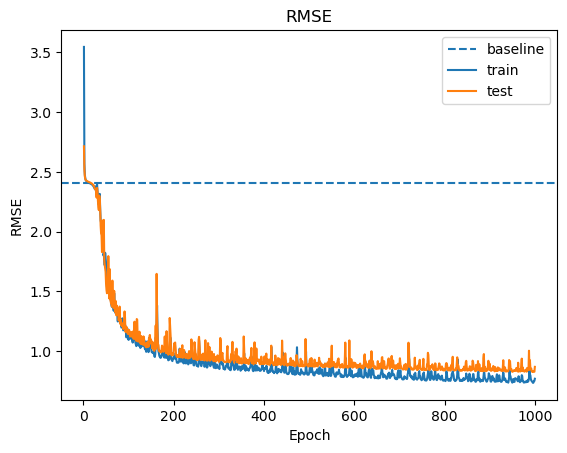

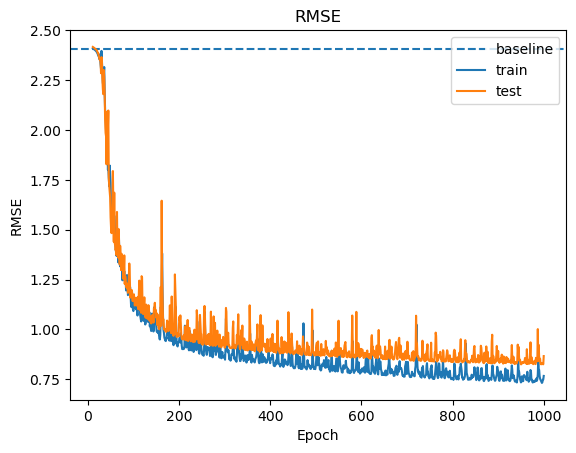

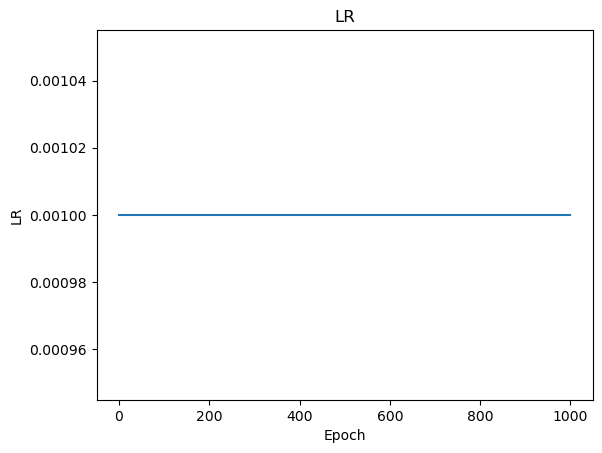

lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▃▃▂▃▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train_time,▂▂▃▃▂▁█▅▃▂▅▂▃▄▃▂▃▃▄▃▂▃▂▄▂▃▄▃▃▃▃▃▃▂▁▂▅▃▃▃
val_loss,█▇▅▃▂▂▃▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_time,▂▂▄▂▁▂█▆▃▂▁▁▃▃▄▂▄▂▅▂▃▃▁▃▃▄█▂▃▃▃▃▁▂▃▃▆▅▃▄
lr,0.001
train_loss,0.76651
train_time,0.13866
val_loss,0.86606
val_time,0.02869


Success


In [16]:
N_EPOCHS = 1000
PATIENCE = 50
FACTOR = 0.3

N_CHANNELS = 20
FIRST_KERNEL_SIZE = 5
KERNEL_SIZE = 10

model = Model(
    n_channels=N_CHANNELS,
    first_kernel_size=FIRST_KERNEL_SIZE,
    kernel_size=KERNEL_SIZE,
).to(device)

LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, factor=FACTOR)
criterion = nn.MSELoss()
torch.manual_seed(0)

experiment_name = f'Convolution_{N_CHANNELS}_channels_{FIRST_KERNEL_SIZE}_{KERNEL_SIZE}_kernel'
notes = f'''
Optimizer: Adam({LR=})
Scheduler: ReduceLROnPlateau({PATIENCE=}, {FACTOR=})
{N_CHANNELS=};
{FIRST_KERNEL_SIZE=};
{KERNEL_SIZE=}
'''

wandb.init(
    project='Oil neural network',
    name=experiment_name,
    notes=notes
)

try:
    train_nn(model, optimizer, criterion, scheduler, train_loader=train_loader, val_loader=val_loader, n_epochs=N_EPOCHS, baseline_rmse=BASELINE_RMSE, plot_baseline=True)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
    wandb.finish()

print('Success')